In [0]:
import os
import argparse
import numpy as np
import pandas as pd
import sys
from datetime import datetime
##Processing all actions of Development process
MY_WORKSPACE_DIR = "/content/drive/My Drive/DNT_Data/"

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

#read the nodes
node_file = MY_WORKSPACE_DIR + 'issue_devdata_flask.csv'
timestamp_col='date'
dateparse = lambda x: datetime.strptime(str(x), '%d/%m/%Y %H:%M')

df_dev = pd.read_csv(node_file ,parse_dates=[timestamp_col], date_parser=dateparse)
df_dev[timestamp_col] = pd.to_datetime(df_dev[timestamp_col])

def extract_timestamp_features(group):
    
    group = group.sort_values(timestamp_col, ascending=False, kind='mergesort')
    
    tmp = group[timestamp_col] - group[timestamp_col].shift(-1)
    tmp.fillna(pd.Timedelta(seconds=0),inplace=True)
    group["timesincelast"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'D'))) # D for days
    

    tmp = group[timestamp_col] - group[timestamp_col].iloc[-1]
    tmp=tmp.fillna(pd.Timedelta(seconds=0))
    group["timesincestart"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'D'))) # D for days
    #tmp=tmp.fillna(pd.Timedelta(seconds=0),inplace=True)

    group = group.sort_values(timestamp_col, ascending=True, kind='mergesort')
    group["event_nr"] = range(1, len(group) + 1)
    
    return group

relevant_action='closed'
def cut_before_action(group):
    relevant_act_idxs = np.where(group['action'] == relevant_action)[0]
    if len(relevant_act_idxs) > 0:
        cut_idx = relevant_act_idxs[0]
        return group[:cut_idx+1]
    else:
        return group



df_dev['userid'] = df_dev['userid'].fillna('NA')
df_dev.index.name=None#
df_dev.reset_index(inplace=True, drop=True)
df_dev = df_dev.groupby('id').apply(extract_timestamp_features)

df_dev.index.name=None
df_dev.reset_index(inplace=True, drop=True)
df_dev = df_dev.sort_values(['id',timestamp_col], kind='mergesort').groupby('id').apply(cut_before_action)
df_dev.index.name=None
df_dev.reset_index(inplace=True, drop=True)
print(df_dev.groupby('id').count())

      userid  date  action  ...  timesincelast  timesincestart  event_nr
id                          ...                                         
13         8     8       8  ...              8               8         8
33         7     7       7  ...              7               7         7
39         2     2       2  ...              2               2         2
40        10    10      10  ...             10              10        10
65         3     3       3  ...              3               3         3
...      ...   ...     ...  ...            ...             ...       ...
3615       2     2       2  ...              2               2         2
3616       4     4       4  ...              4               4         4
3617       2     2       2  ...              2               2         2
3618       2     2       2  ...              2               2         2
3619       2     2       2  ...              2               2         2

[2496 rows x 7 columns]


In [0]:
#labeling functions for non-convergence, non-approval, non-contribution
df_dev = df_dev.sort_values([timestamp_col], ascending=True, kind='mergesort')
dt_first_last_timestamps = df_dev.groupby('id')[timestamp_col].agg([min, max])
dt_first_last_timestamps.columns = ["start_time", "end_time"]
dt_first_last_timestamps['total_time'] = dt_first_last_timestamps['end_time']-dt_first_last_timestamps['start_time']
dt_first_last_timestamps.drop(['start_time', 'end_time'], axis=1)
dt_first_last_timestamps['total_time'] =dt_first_last_timestamps['total_time'].dt.days
#dt_first_last_timestamps['log_time'] = np.log(dt_first_last_timestamps['total_time'])
df_dev = df_dev.merge(dt_first_last_timestamps['total_time'], on='id', how='left')


In [0]:

print(df_dev.groupby('id').count())
df_dev= df_dev[df_dev['total_time']>1]
print(df_dev.groupby('id').count())
ttime = df_dev.quantile([0.50,0.75])['total_time']
print(ttime)

df_num_actions = df_dev.groupby('id').size().reset_index(name='counts')
#df_num_actions.columns=['num_actions']
df_contributors =  df_dev.groupby('id')['userid'].agg(['nunique'])
df_contributors.columns=['num_users']
df_contributors = df_contributors.reset_index()
#print(df_contributors)
#contributors = df_contributors['num_users'].quantile([0.25,0.75])
#actions = df_num_actions['counts'].quantile([0.5,0.75])
#low_act=actions.iloc[0]
#high_act=actions.iloc[1]
#low_contrib = contributors.iloc[0]
#high_contrib = contributors.iloc[1]
#print(low_act, high_act, low_contrib, high_contrib)

df_dev.reset_index(inplace=True, drop=True)
df_dev = df_dev.merge(df_num_actions[['id','counts']], on='id', how='outer')
df_dev = df_dev.merge(df_contributors[['id','num_users']], on='id',  how='outer')

df_dev

      userid  date  action  ...  timesincestart  event_nr  total_time
id                          ...                                      
13         8     8       8  ...               8         8           8
33         7     7       7  ...               7         7           7
39         2     2       2  ...               2         2           2
40        10    10      10  ...              10        10          10
65         3     3       3  ...               3         3           3
...      ...   ...     ...  ...             ...       ...         ...
3615       2     2       2  ...               2         2           2
3616       4     4       4  ...               4         4           4
3617       2     2       2  ...               2         2           2
3618       2     2       2  ...               2         2           2
3619       2     2       2  ...               2         2           2

[2496 rows x 8 columns]
      userid  date  action  ...  timesincestart  event_nr  total_

,id,userid,date,action,approve_date,timesincelast,timesincestart,event_nr,total_time,counts,num_users
0,113,mitsuhiko,2010-04-21 15:44:00,commit,0.0,0.000000,0.000000,1,133,54,6
1,113,mitsuhiko,2010-04-25 15:12:00,commit,0.0,3.977778,3.977778,2,133,54,6
2,113,mitsuhiko,2010-05-02 14:34:00,commit,0.0,6.973611,10.951389,3,133,54,6
3,113,mitsuhiko,2010-05-03 09:20:00,commit,0.0,0.781944,11.733333,4,133,54,6
4,113,mitsuhiko,2010-05-04 10:06:00,commit,0.0,1.031944,12.765278,5,133,54,6
...,...,...,...,...,...,...,...,...,...,...,...
7814,3567,davidism,2020-04-10 17:41:00,comments,0.0,0.469444,0.475000,4,2,6,2
7815,3567,davidism,2020-04-10 17:44:00,comments,0.0,0.002083,0.477083,5,2,6,2
7816,3567,Ma233,2020-04-12 16:04:00,closed,0.0,0.000000,2.407639,6,2,6,2
7817,3608,Sebi2020,2020-05-12 12:17:00,create,NaN,0.000000,0.000000,1,2,2,2


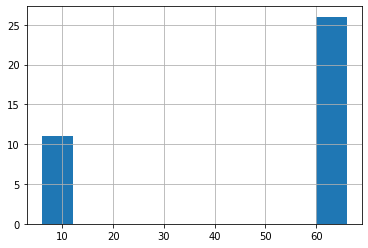

In [0]:
df_dev['approve_date'].hist()

In [0]:
#assign class label
#df_dev=df_dev.to_frame()
low_contrib = 3
low_act=5
high_contrib = 5
high_act=12


df_dev["class_label"] = df_dev['total_time'].apply(lambda x: 1 if x >75 else 0)

df_dev['class_label'].loc[ (df_dev['approve_date']>=15)] = 1 #non-approval

df_dev['class_label'].loc[ (df_dev['counts']<=low_act) & (df_dev['num_users']<=low_contrib) & (df_dev['class_label']==1)] = 2  # non-contribution
df_dev.groupby('class_label').count()
df_dev['class_label'].loc[ (df_dev['counts']>=high_act) & (df_dev['num_users']>=high_contrib) & (df_dev['class_label']==1)] = 3 # non-convergence


print(df_dev.groupby('class_label').count())
print(df_dev.groupby('id').count())

#df_dev
df_dev.to_csv(os.path.join(MY_WORKSPACE_DIR, "process_devprocess_rasa.csv"), sep=";", index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


               id  userid  date  ...  total_time  counts  num_users
class_label                      ...                               
0            3331    3331  3331  ...        3331    3331       3331
1            2059    2059  2059  ...        2059    2059       2059
2             968     968   968  ...         968     968        968
3            1461    1461  1461  ...        1461    1461       1461

[4 rows x 11 columns]
      userid  date  action  ...  counts  num_users  class_label
id                          ...                                
13         8     8       8  ...       8          8            8
33         7     7       7  ...       7          7            7
40        10    10      10  ...      10         10           10
65         3     3       3  ...       3          3            3
68        13    13      13  ...      13         13           13
...      ...   ...     ...  ...     ...        ...          ...
3553       2     2       2  ...       2          2       

In [0]:
from datetime import datetime, timedelta

def read_dataset(filename):
# read dataset
  cat_cols=['userid','action','date']
  dtypes = {col:"object" for col in cat_cols}
  for col in ['timesincelast','timesincestart','event_nr','total_time']:
    dtypes[col] = "float"
  data = pd.read_csv(filename, sep=";", dtype=dtypes)
  data['date'] = pd.to_datetime(data['date'])
  return data

num_days=1
def add_checkpoint(group):
    
    frow =group.iloc[[-1]]
    last_event_date = frow.date.copy()
    frow.action='check_point'
    frow.date= group.iloc[0].date + timedelta(days=num_days)
    frow.timesincestart=num_days
    tsincelast = float((frow.date - last_event_date)/ np.timedelta64(1, 'D'))
    frow.timesincelast= tsincelast
    group=group.append(frow)
    return group

def generate_prefix_data(data, min_length, max_length, time_span=9):
    # generate prefix data (each possible prefix becomes a trace)
    data['case_length'] = data.groupby('id')['action'].transform(len)
    dt_prefixes = data[data['case_length'] >= min_length].groupby('id').head(min_length)
    dt_prefixes["prefix_nr"] = 1
    dt_prefixes["orig_id"] = dt_prefixes['id']
    for nr_days in range(min_length+time_span, max_length+1, time_span):
      tmp = data[data['timesincestart'] <= nr_days].groupby('id').head(nr_days)
      tmp.reset_index()
      tmp["orig_id"] = tmp['id']
      tmp['id'] = tmp['id'].apply(lambda x: "%s_%s"%(x, nr_days))
      tmp["prefix_nr"] = nr_days
      global num_days
      num_days = nr_days
      print(num_days)
      tmp = tmp.groupby('id').apply(add_checkpoint)
      dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)
      #print(dt_prefixes)
        
    dt_prefixes['case_length'] = dt_prefixes['case_length'].apply(lambda x: min(max_length, x))
        
    return dt_prefixes

def split_data(data, train_ratio, split="temporal", seed=20):  
        # split into train and test using temporal split

    grouped = data.groupby('id')
    start_timestamps = grouped['date'].min().reset_index()
    if split == "temporal":
        start_timestamps = start_timestamps.sort_values('date', ascending=True, kind="mergesort")
    elif split == "random":
        np.random.seed(seed)
        start_timestamps = start_timestamps.reindex(np.random.permutation(start_timestamps.index))
    train_ids = list(start_timestamps['id'])[:int(train_ratio*len(start_timestamps))]
    train = data[data['id'].isin(train_ids)].sort_values('date', ascending=True, kind='mergesort')
    test = data[~data['id'].isin(train_ids)].sort_values('date', ascending=True, kind='mergesort')

    return (train, test)

def get_label(data):
    return data.groupby('id').first()['class_label']

def get_prefix_lengths(data):
        return data.groupby('id').last()["prefix_nr"]

In [0]:
#encoder to encode it using aggregation - you may end up with too many resources.

from sklearn.base import TransformerMixin
import pandas as pd
import numpy as np
from time import time
import sys

class AggregateTransformer(TransformerMixin):
    
    def __init__(self, case_id_col, cat_cols, num_cols, boolean=False, fillna=True):
        self.case_id_col = case_id_col
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        self.boolean = boolean
        self.fillna = fillna
        
        self.columns = None
        
        self.fit_time = 0
        self.transform_time = 0
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        start = time()
        
         #add prefix_nr column
        dt_first = X.groupby('id').first()
        
        # add the num_actions and num_users
        dt_prefix = X.groupby(self.case_id_col).size()
        dt_prefix.columns=['actcount']
        #print(dt_prefix)
        

        # transform numeric cols
        if len(self.num_cols) > 0:
            dt_numeric = X.groupby(self.case_id_col)[self.num_cols].agg(['mean', 'max', 'sum'])
            dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]
            
        # transform cat cols
        dt_transformed = pd.get_dummies(X[self.cat_cols])
        dt_transformed[self.case_id_col] = X[self.case_id_col]
        del X
        if self.boolean:
            dt_transformed = dt_transformed.groupby(self.case_id_col).max()
        else:
            dt_transformed = dt_transformed.groupby(self.case_id_col).sum()
        
        # concatenate
        if len(self.num_cols) > 0:
            dt_transformed = pd.concat([dt_transformed, dt_numeric], axis=1)
            dt_transformed = pd.concat([dt_transformed, dt_prefix], axis=1)
            del dt_numeric
            del dt_prefix
       
        # fill missing values with 0-s
        if self.fillna:
            dt_transformed = dt_transformed.fillna(0)
            
        # add missing columns if necessary
        if self.columns is None:
            self.columns = dt_transformed.columns
            
        else:
            missing_cols = [col for col in self.columns if col not in dt_transformed.columns]
            for col in missing_cols:
                dt_transformed[col] = 0
            dt_transformed = dt_transformed[self.columns]
        
        self.transform_time = time() - start
        return dt_transformed
    
    def get_feature_names(self):
        return self.columns

### Experiments - Predicting statis


In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import FeatureUnion, Pipeline
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE



file_name = os.path.join(MY_WORKSPACE_DIR, "process_devprocess_rasa.csv")
data= read_dataset(file_name)
data['userid'] = data['userid'].map(lambda x: str(x).replace('[','').replace(']',''))
print(data.groupby('class_label').count())

train_ratio = 0.70

random_state = 25

parameters={}
parameters = {'learning_rate': [0.25,0.5,0.75],
              'subsample': [0.5,0.75],
               'max_depth': [4,6,10],
                'colsample_bytree': [0.25,0.75],
                'min_child_weight': [1,3,5]}




train, test = split_data(data, train_ratio, split="temporal")


dt_test_prefixes = generate_prefix_data(test, 1, 100)
dt_train_prefixes = generate_prefix_data(train, 1, 100)

dt_train_prefixes.to_csv(os.path.join(MY_WORKSPACE_DIR, "prefixes_flask.csv"), sep=";", index=False)

preds_all = []
test_y_all = []
nr_events_all = []

dt_train_bucket = dt_train_prefixes
dt_test_bucket=dt_test_prefixes
train_y = get_label(dt_train_bucket)
test_y = get_label(dt_test_prefixes)
unique, counts = np.unique(train_y, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_y, return_counts=True)
print(unique, counts)


atx=AggregateTransformer('id', ['action','userid'] , ['timesincelast', 'timesincestart'])

#Flask - 0.8596004575521757
#Flask - {'colsample_bytree': 0.75, 'learning_rate': 0.5, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.75}
cls = xgb.XGBClassifier(objective='multi:softprob',
                        num_class=4,
                        n_estimators=100,
                        learning_rate= 0.5,
                        subsample=0.75,
                        max_depth=10,  #10
                        colsample_bytree=0.25,  #0.25
                        min_child_weight=1,#1
                        seed=random_state)

##########Required for grid search
x_train=atx.fit_transform(dt_train_bucket)
# transform the dataset
print('Training', x_train)
oversample = SMOTE()
x_new, y_new = oversample.fit_resample(x_train, train_y)
x_newdf = pd.DataFrame(x_new, columns=x_train.columns)
#print(x_train.columns)
#cv = GridSearchCV(cls, parameters, scoring = 'f1_macro',cv=3, n_jobs= -1)
#cv.fit(x_newdf, y_new)   
#print(cv.best_score_)    
#print(cv.best_params_) 
#########################
#cls = cv.best_estimator_

cls.fit(x_newdf, y_new)    
test_all_grouped = dt_test_prefixes.groupby('id')           
 # predict separately for each prefix case

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


               id  userid  date  ...  total_time  counts  num_users
class_label                      ...                               
0            3331    3331  3331  ...        3331    3331       3331
1            2059    2059  2059  ...        2059    2059       2059
2             968     968   968  ...         968     968        968
3            1461    1461  1461  ...        1461    1461       1461

[4 rows x 11 columns]
10
19
28
37
46
55
64
73
82
91
100
10
19
28
37
46
55
64
73
82
91
100
[0 1 2 3] [4512 2232 2340  744]
[0 1 2 3] [2544  744  804  132]
Training         action_check_point  action_closed  ...  timesincestart_sum  0
id                                         ...                       
13                       0              0  ...              0.0000  1
33                       0              0  ...              0.0000  1
40                       0              0  ...              0.0000  1
65                       0              0  ...              0.0000  1
68      

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1 macrof1 0.45058300898897236
{'0': {'precision': 0.6006006006006006, 'recall': 0.9433962264150944, 'f1-score': 0.7339449541284404, 'support': 212}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 62}, '2': {'precision': 0.125, 'recall': 0.014925373134328358, 'f1-score': 0.02666666666666667, 'support': 67}, '3': {'precision': 0.14285714285714285, 'recall': 0.09090909090909091, 'f1-score': 0.1111111111111111, 'support': 11}, 'accuracy': 0.5738636363636364, 'macro avg': {'precision': 0.21711443586443585, 'recall': 0.2623076726146284, 'f1-score': 0.21793068297655455, 'support': 352}, 'weighted avg': {'precision': 0.38998226107601114, 'recall': 0.5738636363636364, 'f1-score': 0.45058300898897236, 'support': 352}}
10 macrof1 0.5856990330704942
{'0': {'precision': 0.7407407407407407, 'recall': 0.660377358490566, 'f1-score': 0.6982543640897756, 'support': 212}, '1': {'precision': 0.3684210526315789, 'recall': 0.3387096774193548, 'f1-score': 0.3529411764705882, 'support': 62

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


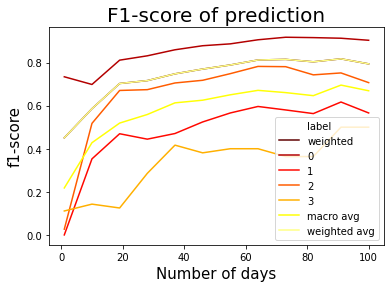

In [0]:


for _, group in test_all_grouped:
    pr_len = get_prefix_lengths(group)                    
    test_y_all.extend(get_label(group))
    x_test = atx.fit_transform(group)
    x_testdf = pd.DataFrame(x_test, columns=atx.get_feature_names())
    pred = cls.predict(x_testdf)
    #print(pred)
    preds_all.extend(pred)
    nr_events_all.extend(pr_len)

num_days = []
f1_list = []
f1_label=[]

      
dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})

for nr_events, group in dt_results.groupby("nr_events"):
    if len(set(group.actual)) < 2:
        print(nr_events, " macof1", np.nan)
    else:
        score=f1_score(group.actual, np.round(group.predicted), average='weighted')
        cls_report = classification_report(group.actual, np.round(group.predicted), output_dict=True)
        print( nr_events, "macrof1", score )
        num_days.append(nr_events)
        f1_list.append(score)
        f1_label.append("weighted")
        print(cls_report)
        for label,val in cls_report.items():
          if type(val)==dict:
            f1_list.append(val['f1-score'])
            f1_label.append(label)
            num_days.append(nr_events)

#print(f1_score(dt_results.actual, np.round(dt_results.predicted)), average='weighted'   )

dt_plot = pd.DataFrame({"num_days": num_days, "label": f1_label, "score": f1_list})


import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
%matplotlib inline
 
# Draw line plot of size and total_bill with parameters
sns.lineplot(x = "num_days", y = "score", data = dt_plot, hue = "label",
            style = "label", palette = "hot", dashes = False, legend="brief",)
 
plt.title("F1-score of prediction", fontsize = 20) # for title
plt.xlabel("Number of days", fontsize = 15) # label for x-axis
plt.ylabel("f1-score", fontsize = 15) # label for y-axis
plt.show()
#dt_prefixes.to_csv(os.path.join(MY_WORKSPACE_DIR, "process_devprocess_rasa_prefixes.csv"), sep=";", index=False)

In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import FeatureUnion, Pipeline
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE



file_name = os.path.join(MY_WORKSPACE_DIR, "process_devprocess_rasa.csv")
data= read_dataset(file_name)
data['userid'] = data['userid'].map(lambda x: str(x).replace('[','').replace(']',''))
print(data.groupby('class_label').count())

train_ratio = 0.70

random_state = 25

parameters={}




train, test = split_data(data, train_ratio, split="temporal")


dt_test_prefixes = generate_prefix_data(test, 1, 100)
dt_train_prefixes = generate_prefix_data(train, 1, 100)

dt_train_prefixes.to_csv(os.path.join(MY_WORKSPACE_DIR, "prefixes_rasa.csv"), sep=";", index=False)

preds_all = []
test_y_all = []
nr_events_all = []

dt_train_bucket = dt_train_prefixes
dt_test_bucket=dt_test_prefixes
train_y = get_label(dt_train_bucket)
test_y = get_label(dt_test_prefixes)
unique, counts = np.unique(train_y, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_y, return_counts=True)
print(unique, counts)


atx=AggregateTransformer('id', ['action','userid'] , ['timesincelast', 'timesincestart'])
#'colsample_bytree': 0.75, 'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.75
#{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.75} - best params flask

#{'colsample_bytree': 0.25, 'learning_rate': 0.25, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.75}
 cls = RandomForestClassifier(n_estimators=500,
                              max_features=args['max_features'],
                              random_state=random_state)
 

##########Required for grid search
x_train=atx.fit_transform(dt_train_bucket)
# transform the dataset
print('Training', x_train)
oversample = SMOTE()
x_new, y_new = oversample.fit_resample(x_train, train_y)
x_newdf = pd.DataFrame(x_new, columns=x_train.columns)
print(x_train.columns)
#cv = GridSearchCV(cls, parameters, scoring = 'f1_macro',cv=3, n_jobs= -1)
#cv.fit(x_newdf, y_new)   
#print(cv.best_score_)    
#print(cv.best_params_) 
#########################
#cls = cv.best_estimator_

cls.fit(x_newdf, y_new)               
 # predict separately for each prefix case


test_all_grouped = dt_test_prefixes.groupby('id')
for _, group in test_all_grouped:
    pr_len = get_prefix_lengths(group)                    
    test_y_all.extend(get_label(group))
    x_test = atx.fit_transform(group)
    x_testdf = pd.DataFrame(x_test, columns=atx.get_feature_names())
    pred = cls.predict(x_testdf)
    #print(pred)
    preds_all.extend(pred)
    nr_events_all.extend(pr_len)

num_days = []
f1_list = []

      
dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
for nr_events, group in dt_results.groupby("nr_events"):
    if len(set(group.actual)) < 2:
        print(nr_events, " macof1", np.nan)
    else:
        score=f1_score(group.actual, np.round(group.predicted), average='weighted')
        print(classification_report(group.actual, np.round(group.predicted)))
        print( nr_events, "macrof1", score )
        num_days.append(nr_events)
        f1_list.append(score)

#print(f1_score(dt_results.actual, np.round(dt_results.predicted)), average='weighted'   )

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(num_days, f1_list)
plt.xlabel('days')
plt.ylabel('f1 score')  
#dt_prefixes.to_csv(os.path.join(MY_WORKSPACE_DIR, "process_devprocess_rasa_prefixes.csv"), sep=";", index=False)

In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

x_val = atx.fit_transform(dt_test_bucket)
print(x_val.columns)
perm = PermutationImportance(cls, random_state=22).fit(x_val, test_y_all)
eli5.show_weights(perm, feature_names =list(x_val.columns))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


NameError: ignored